# Adjoint法

## 強制振動つきの減衰振り子

$\displaystyle \frac{d^2\phi}{dt^2}=-\left(\frac{2\pi}{T_p}\right)\sin\phi-\gamma\frac{d\phi}{dt}+f\cos\phi\sin\left(\frac{2\pi t}{T_f}\right)$

のような強制振動付きの減衰振り子をオイラー法，あるいは修正オイラー法で解くモデルを考える．

オイラー法は微分方程式
$\displaystyle \frac{dx}{dt}=g(x, t)$
を

$x_{k+1}=x_k+g(x_k, t_k)\Delta t$

のような手続きで解き，修正オイラー法は，

$x_{k+1}=x_k+g\left(x_k+\frac{g(x_k,t_k)\Delta t}{2}, t_k+\frac{\Delta t}{2}\right)\Delta t$

のような手続きで解く．

In [106]:
import numpy as np
import numpy.random as ran
import matplotlib.pylab as plt

Ndim = 2 # 状態 x の次元
Nobs = 1 # 観測 y の次元
dt = 0.5 # 時間刻み
Tmax = 1200 # 全時間ステップ
robs = 0.1 # 観測誤差の標準偏差
obs_tinterval = 15 # 観測の時間間隔

Tperiod = 30.0
Tforce = 70.0
gamma = 0.01
forcing = 0.03


class Pendulum_state:
  def __init__(self, Tlag = 0):
    self.x = np.zeros(( Tlag + 1, Ndim ))


class Pendulum_model:
  def __init__(self, dt):
    self.dt = dt
    self.a = (2.0*np.pi / Tperiod)**2
    self.g = gamma
    self.f = forcing
    self.omf = 2.0*np.pi / Tforce

## Euler法で解く
  def Euler(self, xst, t):
    Tlen = xst.x.shape[0]
    g0 = np.zeros((Ndim))

    g0[0] = xst.x[0,1]
    g0[1] = - self.a*np.sin(xst.x[0,0]) - self.g*xst.x[0,1] + self.f*np.sin(self.omf*t)*np.cos(xst.x[0,0])

    for k in range(Tlen-1, 0, -1):
      xst.x[k,:] = xst.x[k-1,:]

    xst.x[0,:] += self.dt * g0

## 修正Euler法で解く
  def modifiedEuler(self, xst, t):
    Tlen = xst.x.shape[0]
    g0 = np.zeros((Ndim))
    g1 = np.zeros((Ndim))

    g0[0] = xst.x[0,1]
    g0[1] = - self.a*np.sin(xst.x[0,0]) - self.g*xst.x[0,1] + self.f*np.sin(self.omf*t)*np.cos(xst.x[0,0])

    xt = xst.x[0,:] + self.dt * g0 / 2
    tt = t + self.dt / 2

    g1[0] = xt[1]
    g1[1] = - self.a*np.sin(xt[0]) - self.g*xt[1] + self.f*np.sin(self.omf*tt)*np.cos(xt[0])

    for k in range(Tlen-1, 0, -1):
      xst.x[k,:] = xst.x[k-1,:]

    xst.x[0,:] += self.dt * g1

In [107]:
# 観測の設定
class Pendulum_observation:
  def __init__(self, rsig):
    rarr = rsig * np.ones(( Nobs ))
    self.Rmat = np.diag( rsig*rarr )
    self.Rsqrt = np.diag( rarr )
    self.Rinv = np.diag( 1.0 / (rsig*rarr) )
    self.Hmat = np.zeros((Nobs, Ndim))
    for i in range(Nobs):
      self.Hmat[i,i] = 1.0

  def hobs(self, xst):
    yob = self.Hmat.dot(xst.x[0,:])
    return yob

  def obs_perturbation(self):
    return self.Rsqrt.dot(ran.randn(Nobs))

In [108]:
# State vector
xstate = Pendulum_state( Tmax )

## Pendulum model
xsys = Pendulum_model( dt )

## For synthetic observation
obsm = Pendulum_observation( robs )

## Initialization
xstate.x[0,0] = 0.0
xstate.x[0,1] = 0.2

truefile = open( "true.dat", 'w' )
obsfile = open( "obs.dat", 'w' )
truefile.write("{0:6}{1:12.6f}{2:12.6f}\n".format(0, xstate.x[0,0], xstate.x[0,1]))

ran.seed(seed=100)

## 擬似データの生成
for k in range(1,Tmax+1):
  xsys.modifiedEuler( xstate, k*dt )

  if k % obs_tinterval == 0:
    yobs = obsm.hobs( xstate ) + obsm.obs_perturbation()
    obsfile.write( "{0:6} ".format(k*dt) )
    for i in range(Nobs-1):
      obsfile.write( "{0:15.6f} ".format(yobs[i]) )
    obsfile.write( "{0:15.6f}\n".format(yobs[Nobs-1]) )

  truefile.write("{0:6}{1:12.6f}{2:12.6f}\n".format(k*dt, xstate.x[0,0], xstate.x[0,1]))

truefile.close()
obsfile.close()

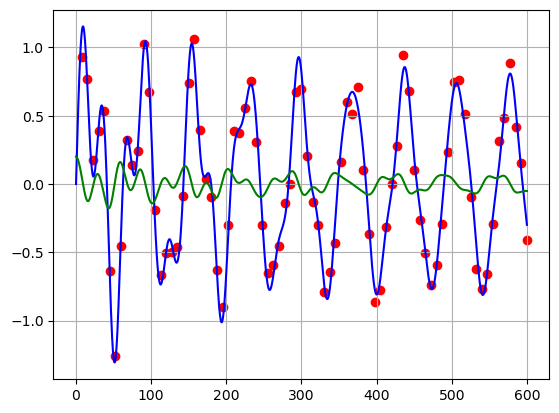

In [109]:
## Plot
xarr = np.loadtxt("true.dat")
yarr = np.loadtxt("obs.dat")
plt.plot( xarr[:,0], xarr[:,1], color='b' )
plt.plot( xarr[:,0], xarr[:,2], color='g' )
plt.scatter( yarr[:,0], yarr[:,1], color='r' )
plt.grid()
plt.show()

In [110]:
class Pendulum_adjoint:
  def __init__(self, dt):
    self.a = (2.0*np.pi / Tperiod)**2
    self.omf = 2.0*np.pi / Tforce
    self.dt = dt

  def modifiedEuler_adjoint(self, xa, t, xf):
    g0 = np.zeros((Ndim))
    
    g0[0] = xf.x[0,1]
    g0[1] = - self.a*np.sin(xf.x[0,0]) - gamma*xf.x[0,1] + forcing*np.sin(self.omf*t)*np.cos(xf.x[0,0])
    
    xt = xf.x[0,:] + self.dt * g0 / 2
    tt = t + self.dt / 2
    
    ## Initialization
    g0a = np.zeros((Ndim))
    g1a = np.zeros((Ndim))
    xta = np.zeros((Ndim))

    g1a[:] = self.dt * xa.x[0,:]

    xta[0] = ( - self.a*np.cos(xt[0])
                - forcing*np.sin(self.omf*tt)*np.sin(xt[0]) ) * g1a[1]
    xta[1] = - gamma * g1a[1]
    xta[1] += g1a[0]

    xa.x[0,:] += xta[:]

    g0a[:] += (self.dt * 0.5) * xta[:]
    xa.x[0,0] += ( - self.a*np.cos(xf.x[0,0])
                - forcing*np.sin(self.omf*t)*np.sin(xf.x[0,0]) ) * g0a[1]
    xa.x[0,1] += - gamma * g0a[1]
    xa.x[0,1] += g0a[0]

In [111]:
import copy

Twin = 120 ## Assimilation window

## DA parameters
Niter = 30
epsilon = 0.0001
ecri = 1.0e-6
robs = 0.1 # Standard deviation of observation noise

xsysm = Pendulum_model( dt )
xadjm = Pendulum_adjoint( dt )

obmodel = Pendulum_observation( robs )
RHt = obmodel.Hmat.T / robs**2

Binv = np.diag([1.0, 25.0])

yobs = np.loadtxt("obs.dat")
xest = np.zeros((Tmax+1, Ndim))

delx = np.zeros((Ndim))
xinit = Pendulum_state( )

for kt in range(0, Tmax, Twin):
# Minimizing the cost function with gradient descent method
  for m in range(Niter):
    j0 = int(kt / obs_tinterval)
    j1 = int((kt + Twin) / obs_tinterval)
    yf = yobs[j0:j1,1:].copy()

    xf = [None] * (Twin+1)
    xf[0] = copy.deepcopy(xinit)

    Jcost = 0.0
## Forward
    for k in range(1,Twin+1):
      xf[k] = copy.deepcopy(xf[k-1]) ## Save the history
      xsysm.modifiedEuler( xf[k], (kt+k)*dt )

      if k % obs_tinterval == 0:
        j = int(k / obs_tinterval) - 1
        yf[j,:] -= obmodel.hobs( xf[k] )
        Jcost += yf[j,:].dot(yf[j,:])/robs**2

    Jcost = Jcost / 2
#    print( "Iter {0}: J={1}".format(m, Jcost) )

## Adjoint
    xad = Pendulum_state( )
    for k in range(Twin,0,-1):
      if k % obs_tinterval == 0:
        j = int(k / obs_tinterval) - 1
        xad.x[0,:] += RHt.dot( yf[j,:] )
      xadjm.modifiedEuler_adjoint( xad, (kt+k-1)*dt, xf[k-1] )
                    
    delx = epsilon * (xad.x[0,:] - Binv.dot(xinit.x[0,:]))
    xinit.x += delx

    if np.sum( delx * delx ) < ecri:
      break
## Iteration loop end

#  print( "Iter {0}: J={1}".format(m, Jcost) )
#  print(xinit.x[:])

  xf[0] = copy.deepcopy(xinit)
  xest[kt,:] = xf[0].x[:]

  for k in range(1,Twin+1):
    xsysm.modifiedEuler( xf[0], (kt+k)*dt )
    xest[kt+k,:] = xf[0].x[:]

  xinit = copy.deepcopy(xf[0])

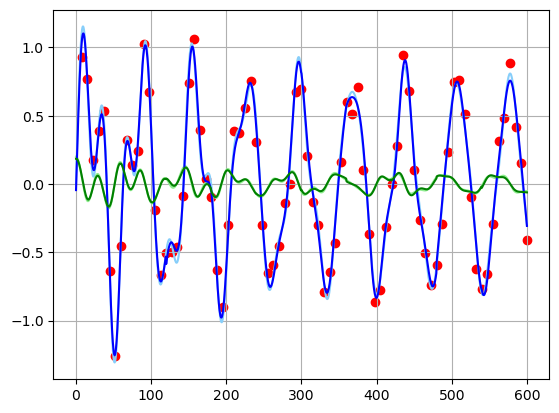

In [112]:
## Plot
xtruth = np.loadtxt( "true.dat",)
plt.plot( xtruth[:,0], xtruth[:,1], color='LightSkyBlue' )
plt.plot( xtruth[:,0], xtruth[:,2], color='LightGreen' )

plt.plot( xtruth[:,0], xest[:,0], color='b' )
plt.plot( xtruth[:,0], xest[:,1], color='g' )

plt.scatter( yobs[:,0], yobs[:,1], color='r' )
plt.grid()
plt.show()